In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Loading Libraries

import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataset import random_split
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchsummary import summary
from matplotlib.ticker import MaxNLocator
import torchvision.models as models


# Importing The Images

In [3]:
# Importing the dataset

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/brain_MRI', transform=transform)

# Verify class labels
print(dataset.class_to_idx)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

{'no': 0, 'yes': 1}


In [4]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


Class: yes


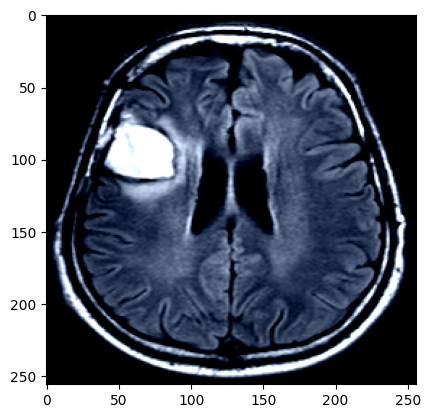

Class: no


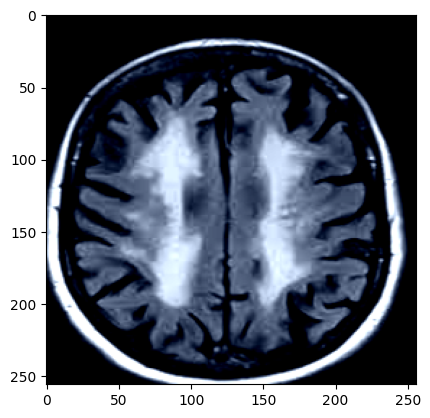

In [5]:
# Define the number of images you want to display from each class
num_images_to_show = 1

# Track the number of images displayed per class
images_shown = {"no": 0, "yes": 0}

# Iterate over the dataset and display images
for images, labels in dataloader:
    for i, label in enumerate(labels):
        class_name = dataset.classes[label]
        if images_shown[class_name] < num_images_to_show:
            print(f"Class: {class_name}")
            imshow(images[i])
            images_shown[class_name] += 1
            if all(count >= num_images_to_show for count in images_shown.values()):
                break
    if all(count >= num_images_to_show for count in images_shown.values()):
        break


# Data Preparation

In [6]:
# Data Splitting at 60-20-20 ratio

seed = 42
torch.manual_seed(seed)
random.seed(seed)

total_size = len(dataset)
train_size = int(0.60 * total_size)
val_size = int(0.20 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")



Training dataset size: 151
Validation dataset size: 50
Testing dataset size: 52


In [7]:
# Data Augmentation

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
])

class AugmentedDataset(Dataset):
    def __init__(self, dataset, transform=None, augmentation_factor=5):
        self.dataset = dataset
        self.transform = transform
        self.augmentation_factor = augmentation_factor

    def __len__(self):
        return len(self.dataset) * self.augmentation_factor

    def __getitem__(self, idx):
        # Find the original image index
        original_idx = idx // self.augmentation_factor
        image, label = self.dataset[original_idx]

        if self.transform:
            # Apply transformation
            image = self.transform(image)

        return image, label

# Use the AugmentedDataset
train_dataset_augmented = AugmentedDataset(train_dataset, transform=train_transforms, augmentation_factor=5)

train_loader = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)

print(f"Training dataset size: {len(train_dataset_augmented)}")


Training dataset size: 755


# Model Implementation

## Base Model without Batch Norm

In [24]:
# Define the Base CNN architecture

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Calculate the size of the flattened feature maps for the first fully connected layer
        self._to_linear = None
        self.calculate_to_linear()

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)  # 2 outputs for binary classification

    def calculate_to_linear(self):
        # Dummy input to get the size after conv layers
        with torch.no_grad():
            x = self.convs(torch.zeros(1, 3, 256, 256))
            self._to_linear = np.prod(x.size()[1:])


    def convs(self, x):
        # Apply convolutional layers and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x

    def forward(self, x):
        x = self.convs(x)
        num_features = np.prod(x.size()[1:])  # Dynamically calculate the number of features
        x = x.view(-1, num_features)
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
model = SimpleCNN()


In [9]:
# Generate Model Architecture Summary

model = SimpleCNN()
if torch.cuda.is_available():
    model.to('cuda')
    summary(model, input_size=(3, 256, 256), device='cuda')
else:
    model.to('cpu')
    summary(model, input_size=(3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
         MaxPool2d-2         [-1, 32, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          18,496
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 64, 64]          73,856
         MaxPool2d-6          [-1, 128, 32, 32]               0
            Linear-7                  [-1, 512]      67,109,376
            Linear-8                  [-1, 128]          65,664
            Linear-9                    [-1, 2]             258
Total params: 67,268,546
Trainable params: 67,268,546
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 35.00
Params size (MB): 256.61
Estimated Total Size (MB): 292.36
--------------------------------

### Gradient Descent

In [10]:
# Instantiate the model
model = SimpleCNN()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.00001,  momentum=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
best_epoch = 0

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        # Save the model state
        torch.save(model.state_dict(), '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_Simple_GD.pth')
        print(f"Best model saved at epoch {epoch+1} with Validation Loss: {avg_val_loss:.4f}")

    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Best model saved at epoch 1 with Validation Loss: 0.6887
Epoch [1/20], Train Loss: 0.6883, Train Acc: 58.94%, Val Loss: 0.6887, Val Acc: 62.00%
Best model saved at epoch 2 with Validation Loss: 0.6848
Epoch [2/20], Train Loss: 0.6881, Train Acc: 58.94%, Val Loss: 0.6848, Val Acc: 62.00%
Epoch [3/20], Train Loss: 0.6882, Train Acc: 58.94%, Val Loss: 0.6866, Val Acc: 62.00%
Best model saved at epoch 4 with Validation Loss: 0.6845
Epoch [4/20], Train Loss: 0.6885, Train Acc: 58.94%, Val Loss: 0.6845, Val Acc: 62.00%
Epoch [5/20], Train Loss: 0.6884, Train Acc: 58.94%, Val Loss: 0.6847, Val Acc: 62.00%
Epoch [6/20], Train Loss: 0.6883, Train Acc: 58.94%, Val Loss: 0.6871, Val Acc: 62.00%
Epoch [7/20], Train Loss: 0.6883, Train Acc: 58.94%, Val Loss: 0.6874, Val Acc: 62.00%
Epoch [8/20], Train Loss: 0.6882, Train Acc: 58.94%, Val Loss: 0.6857, Val Acc: 62.00%
Epoch [9/20], Train Loss: 0.6885, Train Acc: 58.94%, Val Loss: 0.6858, Val Acc: 62.00%
Epoch [10/20], Train Loss: 0.6884, Train Acc: 

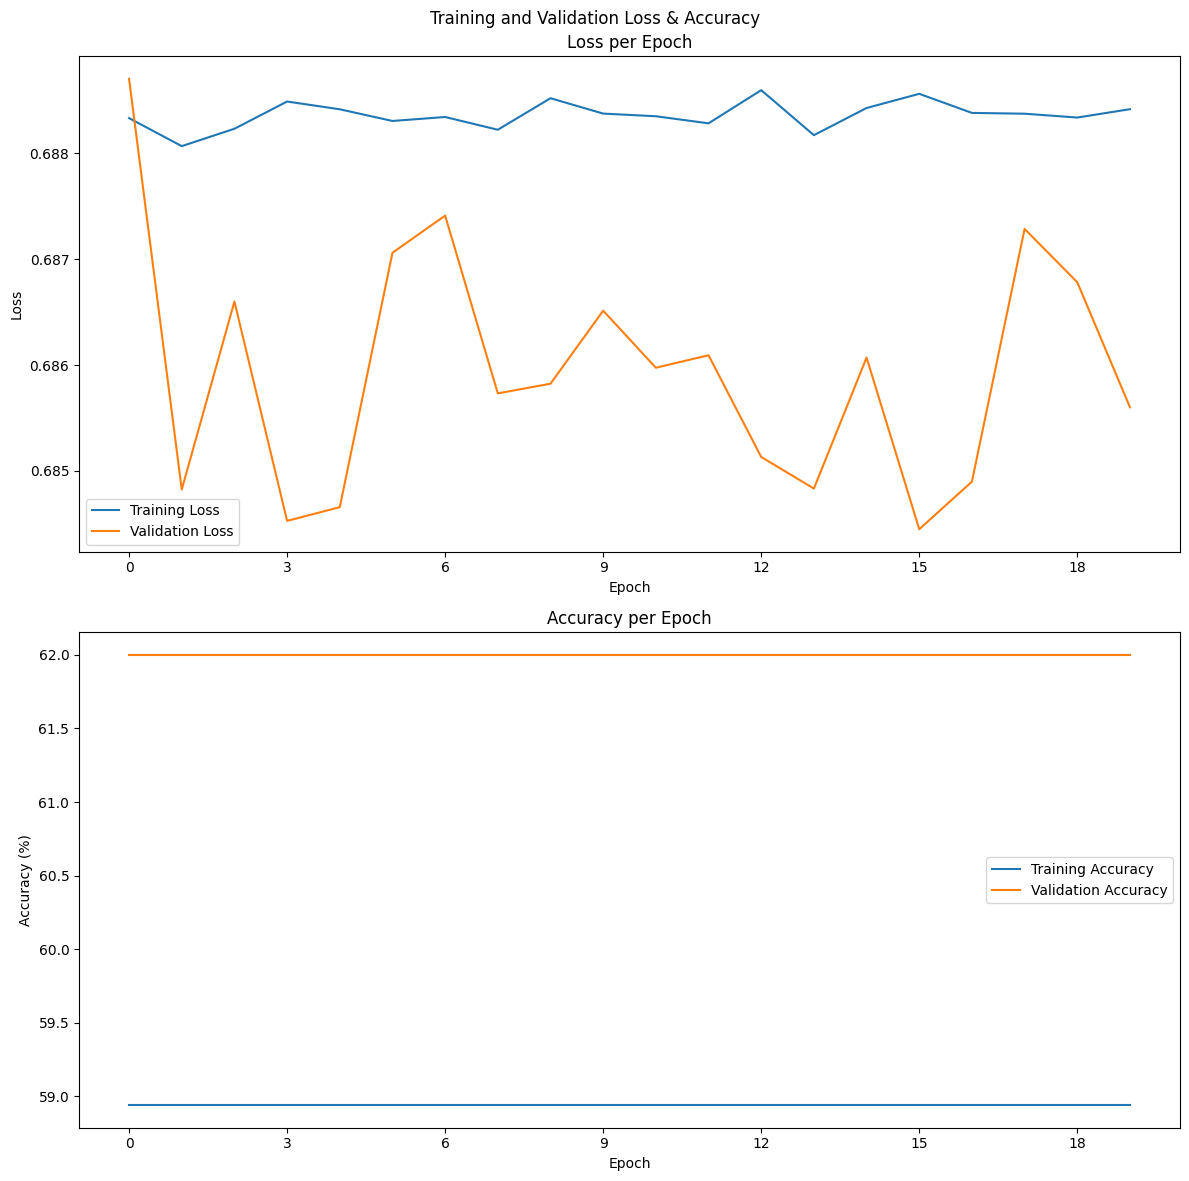

Best Model was at epoch 16 with Validation Loss: 0.6844


In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Training and Validation Loss & Accuracy')

# Plot for loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss per Epoch')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plot for accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.set_title('Accuracy per Epoch')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

print(f"Best Model was at epoch {best_epoch+1} with Validation Loss: {best_val_loss:.4f}")

Simple_GD_train_losses = train_losses
Simple_GD_train_acc = train_accuracies
Simple_GD_val_losses = val_losses
Simple_GD_val_acc = val_accuracies

In [12]:
# Evaluating the model

# Load the best model
best_model_path = '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_Simple_GD.pth'
model.load_state_dict(torch.load(best_model_path, map_location=device))

model.eval()

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.6874, Test Accuracy: 67.31%


### Stochastic Gradient Descent

In [19]:
# Instantiate the model
model = SimpleCNN()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.00001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
best_epoch = 0

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        # Save the model state
        torch.save(model.state_dict(), '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_Simple_SGD.pth')
        print(f"Best model saved at epoch {epoch+1} with Validation Loss: {avg_val_loss:.4f}")

    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Best model saved at epoch 1 with Validation Loss: 0.6786
Epoch [1/20], Train Loss: 0.6835, Train Acc: 58.94%, Val Loss: 0.6786, Val Acc: 62.00%
Best model saved at epoch 2 with Validation Loss: 0.6756
Epoch [2/20], Train Loss: 0.6831, Train Acc: 58.94%, Val Loss: 0.6756, Val Acc: 62.00%
Epoch [3/20], Train Loss: 0.6829, Train Acc: 58.94%, Val Loss: 0.6768, Val Acc: 62.00%
Best model saved at epoch 4 with Validation Loss: 0.6755
Epoch [4/20], Train Loss: 0.6832, Train Acc: 58.94%, Val Loss: 0.6755, Val Acc: 62.00%
Epoch [5/20], Train Loss: 0.6836, Train Acc: 58.94%, Val Loss: 0.6757, Val Acc: 62.00%
Epoch [6/20], Train Loss: 0.6831, Train Acc: 58.94%, Val Loss: 0.6773, Val Acc: 62.00%
Best model saved at epoch 7 with Validation Loss: 0.6745
Epoch [7/20], Train Loss: 0.6828, Train Acc: 58.94%, Val Loss: 0.6745, Val Acc: 62.00%
Epoch [8/20], Train Loss: 0.6830, Train Acc: 58.94%, Val Loss: 0.6759, Val Acc: 62.00%
Epoch [9/20], Train Loss: 0.6831, Train Acc: 58.94%, Val Loss: 0.6771, Val A

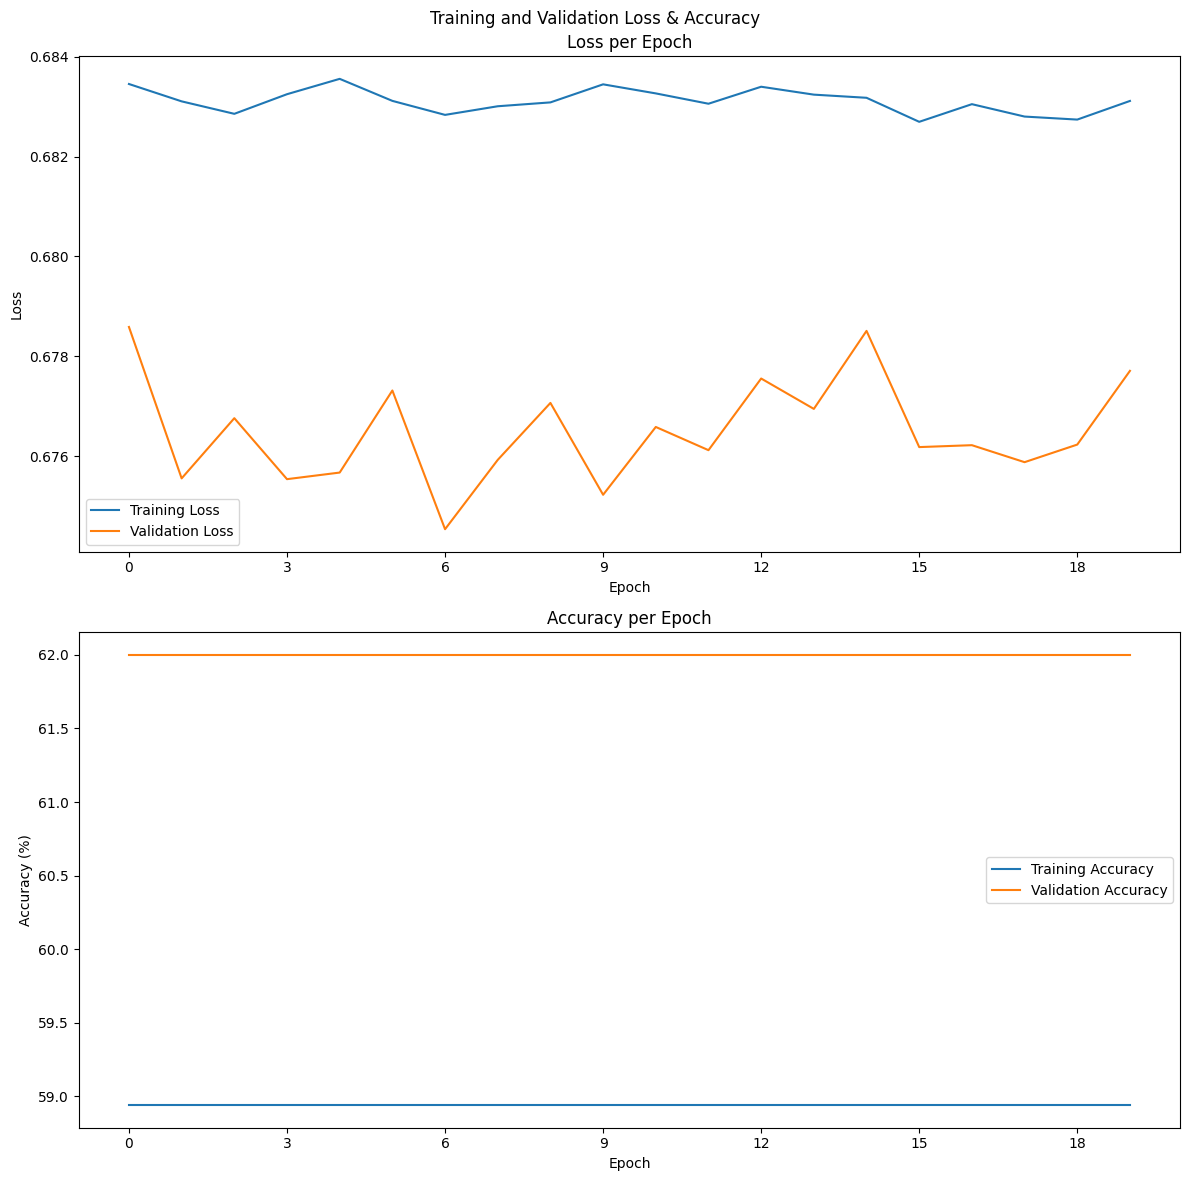

Best Model was at epoch 7 with Validation Loss: 0.6745


In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Training and Validation Loss & Accuracy')

# Plot for loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss per Epoch')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plot for accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.set_title('Accuracy per Epoch')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

print(f"Best Model was at epoch {best_epoch+1} with Validation Loss: {best_val_loss:.4f}")

Simple_SGD_train_losses = train_losses
Simple_SGD_train_acc = train_accuracies
Simple_SGD_val_losses = val_losses
Simple_SGD_val_acc = val_accuracies

In [21]:
# Evaluating the model

# Load the best model
best_model_path = '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_Simple_SGD.pth'
model.load_state_dict(torch.load(best_model_path, map_location=device))

model.eval()

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.6707, Test Accuracy: 67.31%


### RMSprop

In [26]:
# Instantiate the model
model = SimpleCNN()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.00001, weight_decay = 0.00001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
best_epoch = 0

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        # Save the model state
        torch.save(model.state_dict(), '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_Simple_RMSprop.pth')
        print(f"Best model saved at epoch {epoch+1} with Validation Loss: {avg_val_loss:.4f}")

    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


Best model saved at epoch 1 with Validation Loss: 0.7445
Epoch [1/20], Train Loss: 0.6730, Train Acc: 58.54%, Val Loss: 0.7445, Val Acc: 62.00%
Epoch [2/20], Train Loss: 0.6611, Train Acc: 58.94%, Val Loss: 0.7872, Val Acc: 62.00%
Best model saved at epoch 3 with Validation Loss: 0.5960
Epoch [3/20], Train Loss: 0.6440, Train Acc: 61.32%, Val Loss: 0.5960, Val Acc: 68.00%
Epoch [4/20], Train Loss: 0.6361, Train Acc: 63.97%, Val Loss: 0.6155, Val Acc: 68.00%
Epoch [5/20], Train Loss: 0.6375, Train Acc: 64.50%, Val Loss: 0.6472, Val Acc: 68.00%
Epoch [6/20], Train Loss: 0.6244, Train Acc: 65.30%, Val Loss: 0.6108, Val Acc: 70.00%
Epoch [7/20], Train Loss: 0.6188, Train Acc: 66.49%, Val Loss: 0.6227, Val Acc: 72.00%
Epoch [8/20], Train Loss: 0.6107, Train Acc: 66.36%, Val Loss: 0.7428, Val Acc: 68.00%
Epoch [9/20], Train Loss: 0.6276, Train Acc: 67.42%, Val Loss: 0.6559, Val Acc: 70.00%
Epoch [10/20], Train Loss: 0.6160, Train Acc: 67.55%, Val Loss: 0.6209, Val Acc: 74.00%
Epoch [11/20], 

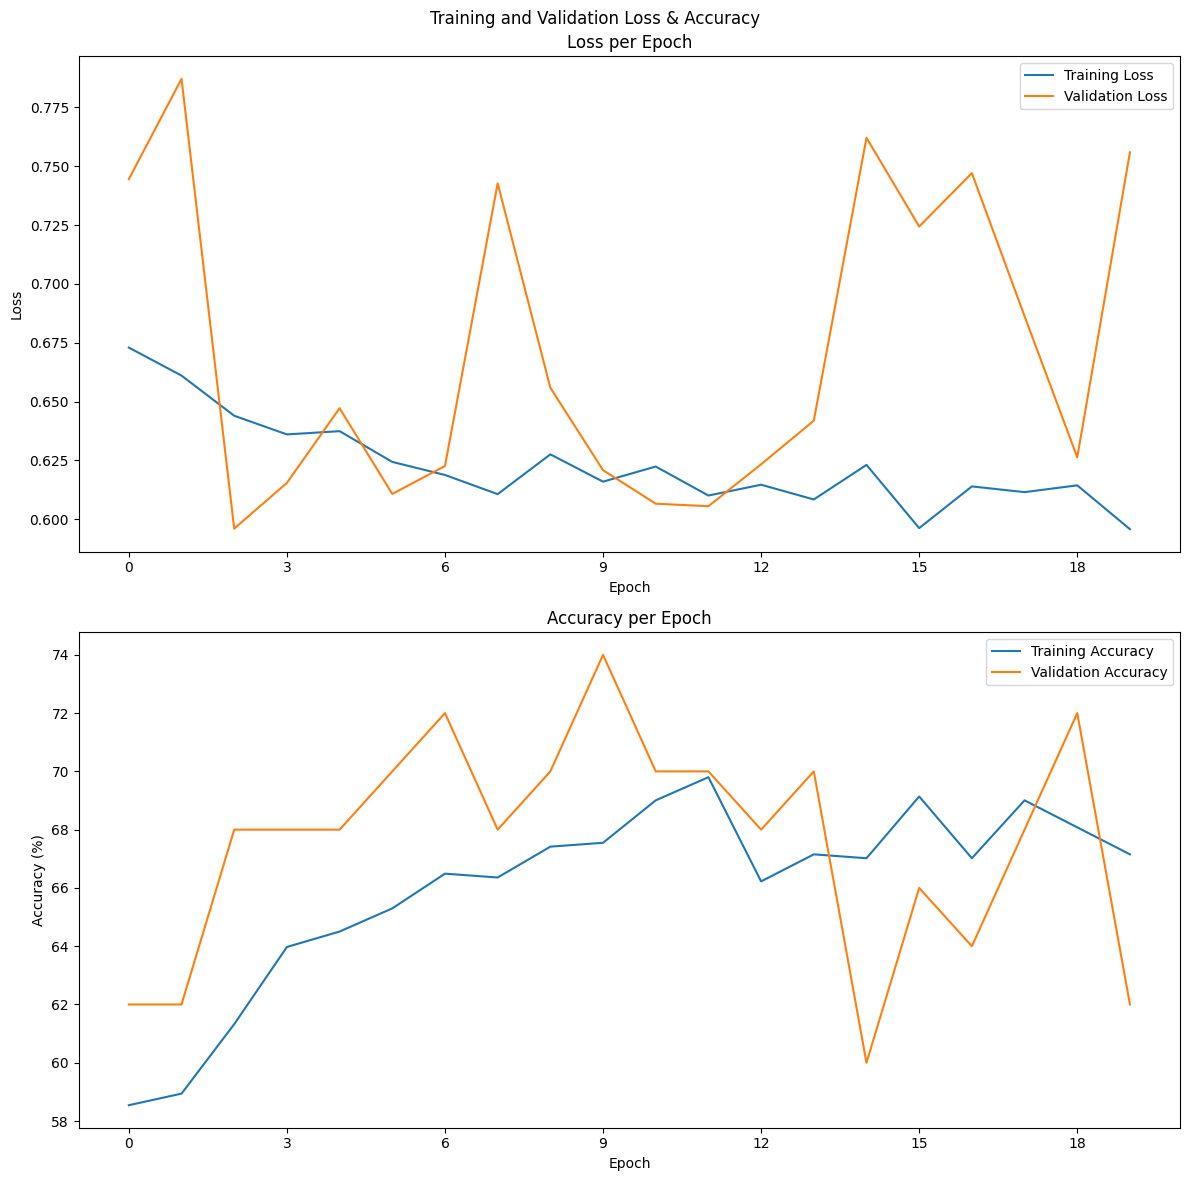

Best Model was at epoch 3 with Validation Loss: 0.5960


In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Training and Validation Loss & Accuracy')

# Plot for loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss per Epoch')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plot for accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.set_title('Accuracy per Epoch')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

print(f"Best Model was at epoch {best_epoch+1} with Validation Loss: {best_val_loss:.4f}")

Simple_RMSprop_train_losses = train_losses
Simple_RMSprop_train_acc = train_accuracies
Simple_RMSprop_val_losses = val_losses
Simple_RMSprop_val_acc = val_accuracies

In [28]:
# Evaluating the model

# Load the best model
best_model_path = '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_Simple_RMSprop.pth'
model.load_state_dict(torch.load(best_model_path, map_location=device))

model.eval()

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.5731, Test Accuracy: 67.31%


### Adam

In [30]:
# Instantiate the model
model = SimpleCNN()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay = 0.00001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
best_epoch = 0

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        # Save the model state
        torch.save(model.state_dict(), '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_Simple_Adam.pth')
        print(f"Best model saved at epoch {epoch+1} with Validation Loss: {avg_val_loss:.4f}")

    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


Best model saved at epoch 1 with Validation Loss: 0.7172
Epoch [1/20], Train Loss: 0.6780, Train Acc: 58.54%, Val Loss: 0.7172, Val Acc: 62.00%
Epoch [2/20], Train Loss: 0.6712, Train Acc: 58.94%, Val Loss: 0.7261, Val Acc: 62.00%
Best model saved at epoch 3 with Validation Loss: 0.7031
Epoch [3/20], Train Loss: 0.6639, Train Acc: 58.94%, Val Loss: 0.7031, Val Acc: 62.00%
Best model saved at epoch 4 with Validation Loss: 0.6364
Epoch [4/20], Train Loss: 0.6553, Train Acc: 59.07%, Val Loss: 0.6364, Val Acc: 62.00%
Epoch [5/20], Train Loss: 0.6502, Train Acc: 59.34%, Val Loss: 0.7570, Val Acc: 62.00%
Best model saved at epoch 6 with Validation Loss: 0.6111
Epoch [6/20], Train Loss: 0.6384, Train Acc: 62.12%, Val Loss: 0.6111, Val Acc: 70.00%
Best model saved at epoch 7 with Validation Loss: 0.5854
Epoch [7/20], Train Loss: 0.6435, Train Acc: 63.71%, Val Loss: 0.5854, Val Acc: 70.00%
Epoch [8/20], Train Loss: 0.6297, Train Acc: 64.11%, Val Loss: 0.5933, Val Acc: 70.00%
Epoch [9/20], Train

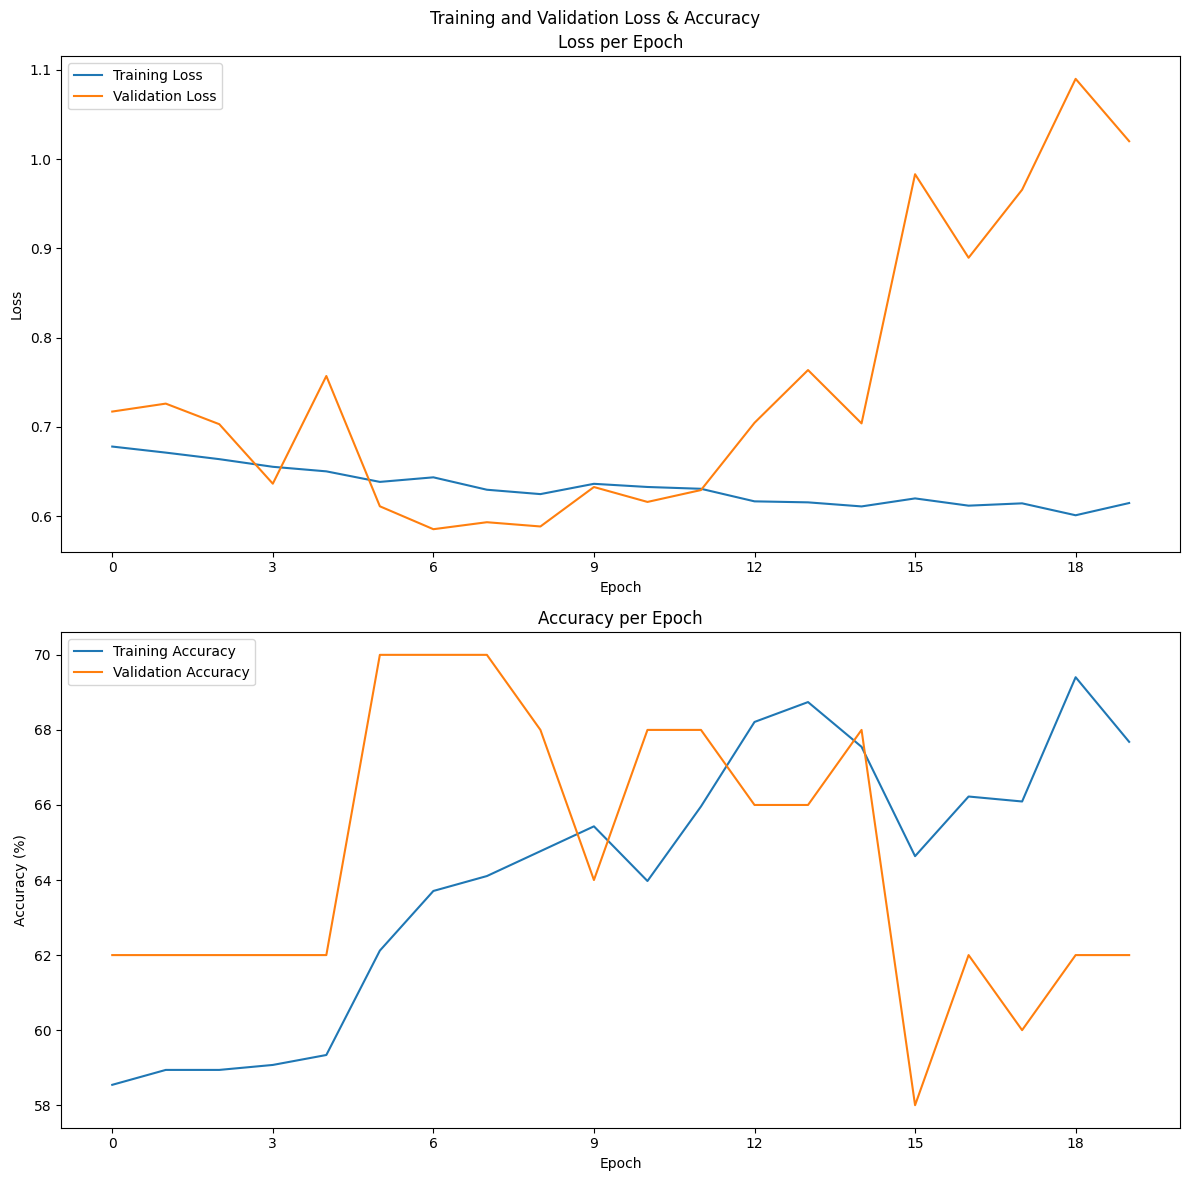

Best Model was at epoch 7 with Validation Loss: 0.5854


In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Training and Validation Loss & Accuracy')

# Plot for loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss per Epoch')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plot for accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.set_title('Accuracy per Epoch')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

print(f"Best Model was at epoch {best_epoch+1} with Validation Loss: {best_val_loss:.4f}")

Simple_Adam_train_losses = train_losses
Simple_Adam_train_acc = train_accuracies
Simple_Adam_val_losses = val_losses
Simple_Adam_val_acc = val_accuracies

In [32]:
# Evaluating the model

# Load the best model
best_model_path = '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_Simple_Adam.pth'
model.load_state_dict(torch.load(best_model_path, map_location=device))

model.eval()

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.5211, Test Accuracy: 71.15%


## Base Model with Batch Norm

In [33]:
class SimpleCNN_bn(nn.Module):
    def __init__(self):
        super(SimpleCNN_bn, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization layer for conv1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization layer for conv2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch Normalization layer for conv3

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Calculate the size of the flattened feature maps for the first fully connected layer
        self._to_linear = None
        self.calculate_to_linear()

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)  # 2 outputs for binary classification

    def calculate_to_linear(self):
        # Dummy input to get the size after conv layers
        with torch.no_grad():
            x = self.convs(torch.zeros(1, 3, 256, 256))
            self._to_linear = np.prod(x.size()[1:])


    def convs(self, x):
        # Apply convolutional layers, batch normalization, and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        x = self.convs(x)
        num_features = np.prod(x.size()[1:])  # Dynamically calculate the number of features
        x = x.view(-1, num_features)
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
model_bn = SimpleCNN_bn()


In [34]:
# Generate Model Architecture Summary

model_bn = SimpleCNN_bn()
if torch.cuda.is_available():
    model_bn.to('cuda')
    summary(model_bn, input_size=(3, 256, 256), device='cuda')
else:
    model_bn.to('cpu')
    summary(model_bn, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
       BatchNorm2d-5         [-1, 64, 128, 128]             128
         MaxPool2d-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
       BatchNorm2d-8          [-1, 128, 64, 64]             256
         MaxPool2d-9          [-1, 128, 32, 32]               0
           Linear-10                  [-1, 512]      67,109,376
           Linear-11                  [-1, 128]          65,664
           Linear-12                    [-1, 2]             258
Total params: 67,268,994
Trainable params: 67,268,994
Non-trainable params: 0
-------------------------

### Gradient Descent

In [35]:
# Instantiate the model
model_bn = SimpleCNN_bn()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_bn.parameters(), lr=0.00001,  momentum=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bn.to(device)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
best_epoch = 0

for epoch in range(num_epochs):
    model_bn.train()  # Set the model to training mode
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass
        outputs = model_bn(images)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model_bn.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model_bn(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        # Save the model state
        torch.save(model_bn.state_dict(), '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_Simple_GD_bn.pth')
        print(f"Best model saved at epoch {epoch+1} with Validation Loss: {avg_val_loss:.4f}")

    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


Best model saved at epoch 1 with Validation Loss: 0.7172
Epoch [1/20], Train Loss: 0.7052, Train Acc: 44.50%, Val Loss: 0.7172, Val Acc: 42.00%
Epoch [2/20], Train Loss: 0.7016, Train Acc: 44.77%, Val Loss: 0.7755, Val Acc: 48.00%
Best model saved at epoch 3 with Validation Loss: 0.6926
Epoch [3/20], Train Loss: 0.7024, Train Acc: 44.64%, Val Loss: 0.6926, Val Acc: 52.00%
Epoch [4/20], Train Loss: 0.6967, Train Acc: 48.74%, Val Loss: 0.7666, Val Acc: 56.00%
Epoch [5/20], Train Loss: 0.6948, Train Acc: 49.80%, Val Loss: 0.7070, Val Acc: 58.00%
Best model saved at epoch 6 with Validation Loss: 0.5866
Epoch [6/20], Train Loss: 0.6865, Train Acc: 52.19%, Val Loss: 0.5866, Val Acc: 68.00%
Epoch [7/20], Train Loss: 0.6941, Train Acc: 50.99%, Val Loss: 0.6362, Val Acc: 66.00%
Epoch [8/20], Train Loss: 0.6884, Train Acc: 52.72%, Val Loss: 0.7359, Val Acc: 54.00%
Epoch [9/20], Train Loss: 0.6860, Train Acc: 55.10%, Val Loss: 0.6638, Val Acc: 64.00%
Epoch [10/20], Train Loss: 0.6853, Train Acc: 

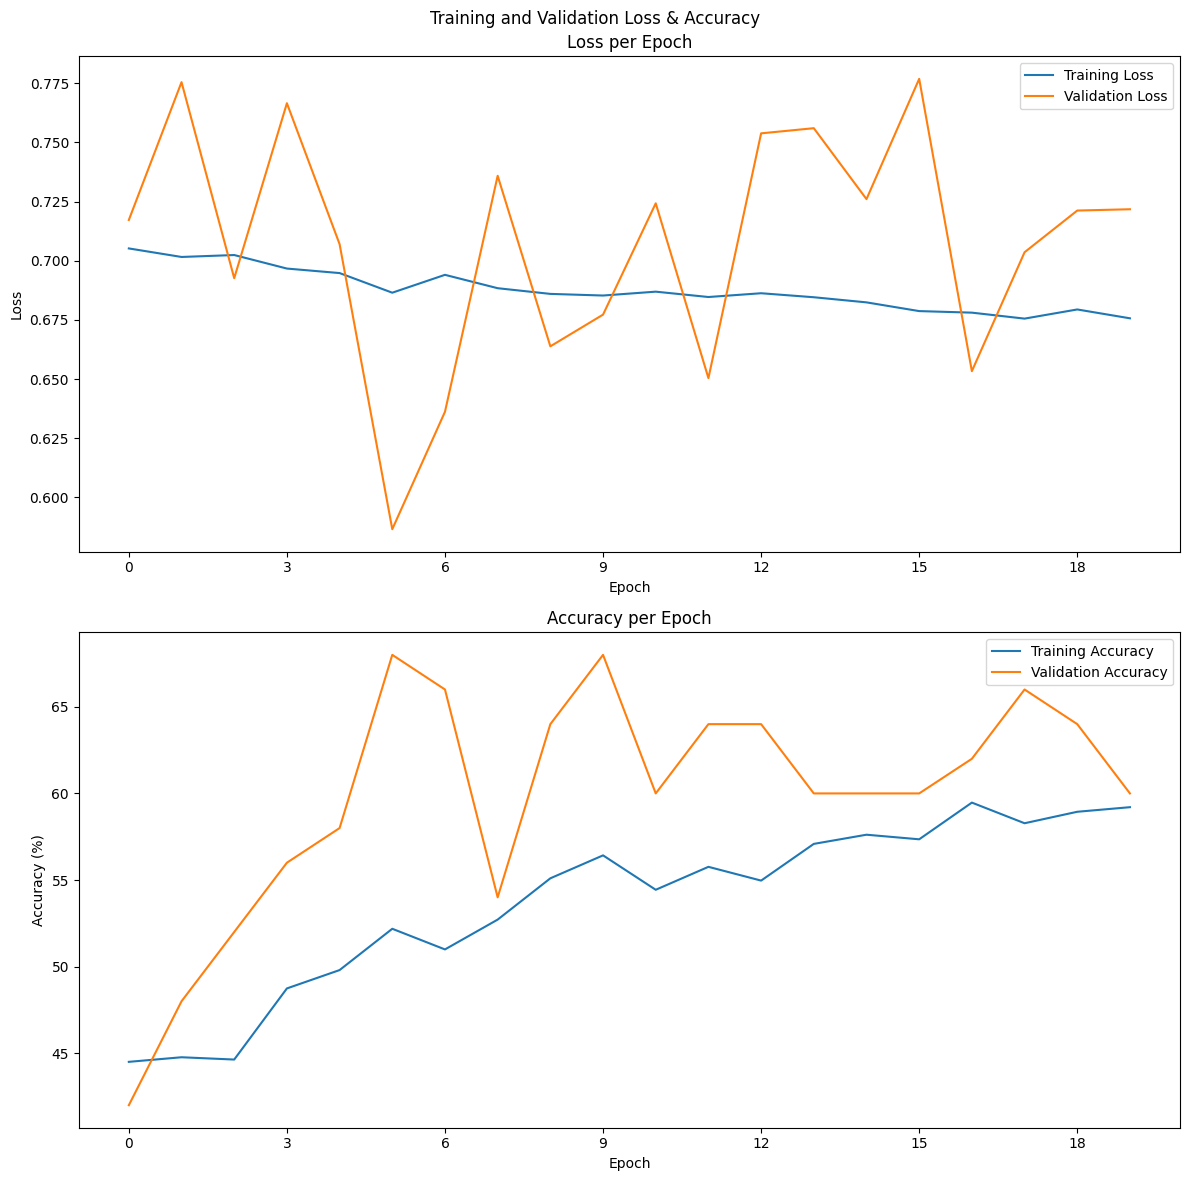

Best Model was at epoch 6 with Validation Loss: 0.5866


In [36]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Training and Validation Loss & Accuracy')

# Plot for loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss per Epoch')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plot for accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.set_title('Accuracy per Epoch')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

print(f"Best Model was at epoch {best_epoch+1} with Validation Loss: {best_val_loss:.4f}")

Simple_GD_bn_train_losses = train_losses
Simple_GD_bn_train_acc = train_accuracies
Simple_GD_bn_val_losses = val_losses
Simple_GD_bn_val_acc = val_accuracies

In [37]:
# Evaluating the model

# Load the best model
best_model_path = '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_Simple_GD_bn.pth'
model_bn.load_state_dict(torch.load(best_model_path, map_location=device))

model_bn.eval()

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_bn(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.7003, Test Accuracy: 53.85%


### Stochastic Gradient Descent

In [38]:
# Instantiate the model
model_bn = SimpleCNN_bn()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_bn.parameters(), lr=0.00001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bn.to(device)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
best_epoch = 0

for epoch in range(num_epochs):
    model_bn.train()  # Set the model to training mode
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass
        outputs = model_bn(images)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model_bn.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model_bn(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        # Save the model state
        torch.save(model_bn.state_dict(), '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_Simple_SGD_bn.pth')
        print(f"Best model saved at epoch {epoch+1} with Validation Loss: {avg_val_loss:.4f}")

    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


Best model saved at epoch 1 with Validation Loss: 0.6885
Epoch [1/20], Train Loss: 0.6952, Train Acc: 51.39%, Val Loss: 0.6885, Val Acc: 54.00%
Epoch [2/20], Train Loss: 0.6986, Train Acc: 49.40%, Val Loss: 0.7281, Val Acc: 50.00%
Best model saved at epoch 3 with Validation Loss: 0.6706
Epoch [3/20], Train Loss: 0.6925, Train Acc: 53.11%, Val Loss: 0.6706, Val Acc: 56.00%
Epoch [4/20], Train Loss: 0.6905, Train Acc: 53.38%, Val Loss: 0.6888, Val Acc: 52.00%
Epoch [5/20], Train Loss: 0.6940, Train Acc: 52.05%, Val Loss: 0.7496, Val Acc: 58.00%
Epoch [6/20], Train Loss: 0.6878, Train Acc: 54.44%, Val Loss: 0.7150, Val Acc: 56.00%
Epoch [7/20], Train Loss: 0.6965, Train Acc: 52.72%, Val Loss: 0.7752, Val Acc: 52.00%
Epoch [8/20], Train Loss: 0.6846, Train Acc: 57.62%, Val Loss: 0.7231, Val Acc: 58.00%
Epoch [9/20], Train Loss: 0.6871, Train Acc: 55.76%, Val Loss: 0.7157, Val Acc: 60.00%
Epoch [10/20], Train Loss: 0.6919, Train Acc: 56.03%, Val Loss: 0.6709, Val Acc: 64.00%
Best model save

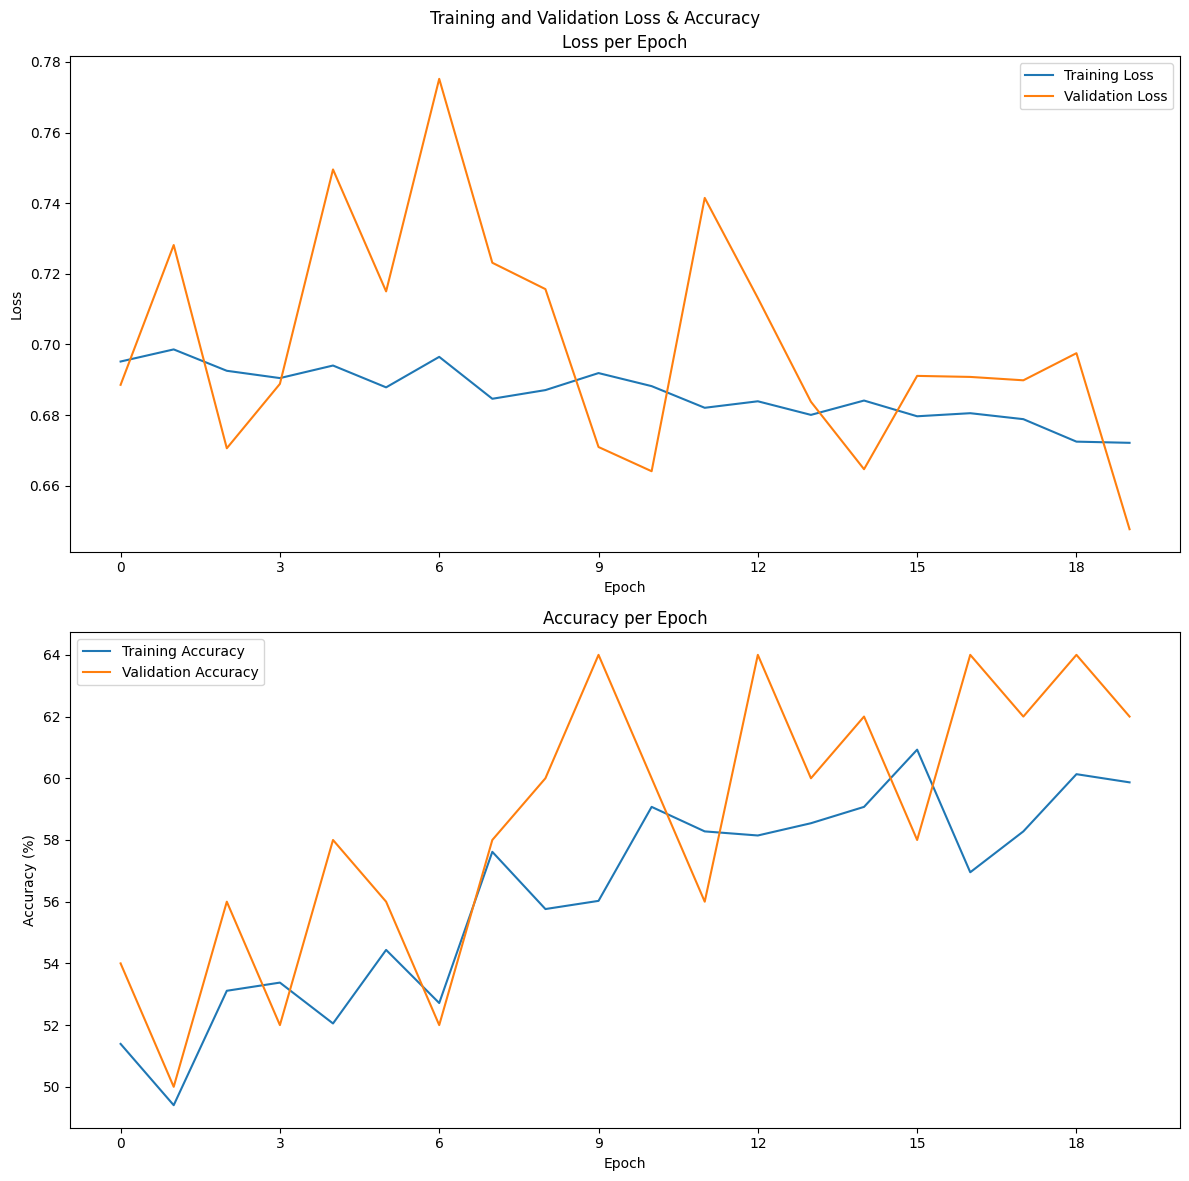

Best Model was at epoch 20 with Validation Loss: 0.6477


In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Training and Validation Loss & Accuracy')

# Plot for loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss per Epoch')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plot for accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.set_title('Accuracy per Epoch')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

print(f"Best Model was at epoch {best_epoch+1} with Validation Loss: {best_val_loss:.4f}")

Simple_SGD_bn_train_losses = train_losses
Simple_SGD_bn_train_acc = train_accuracies
Simple_SGD_bn_val_losses = val_losses
Simple_SGD_bn_val_acc = val_accuracies

In [40]:
# Evaluating the model

# Load the best model
best_model_path = '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_Simple_SGD_bn.pth'
model_bn.load_state_dict(torch.load(best_model_path, map_location=device))

model_bn.eval()

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_bn(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.6673, Test Accuracy: 67.31%


### RMSprop

In [42]:
# Instantiate the model
model_bn = SimpleCNN_bn()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model_bn.parameters(), lr=0.00001, weight_decay = 0.00001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bn.to(device)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
best_epoch = 0

for epoch in range(num_epochs):
    model_bn.train()  # Set the model to training mode
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass
        outputs = model_bn(images)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model_bn.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model_bn(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        # Save the model state
        torch.save(model_bn.state_dict(), '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_Simple_RMSprop_bn.pth')
        print(f"Best model saved at epoch {epoch+1} with Validation Loss: {avg_val_loss:.4f}")

    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


Best model saved at epoch 1 with Validation Loss: 0.6513
Epoch [1/20], Train Loss: 0.8144, Train Acc: 57.88%, Val Loss: 0.6513, Val Acc: 62.00%
Epoch [2/20], Train Loss: 0.6429, Train Acc: 64.50%, Val Loss: 0.6924, Val Acc: 66.00%
Epoch [3/20], Train Loss: 0.6159, Train Acc: 67.55%, Val Loss: 1.4213, Val Acc: 64.00%
Best model saved at epoch 4 with Validation Loss: 0.6391
Epoch [4/20], Train Loss: 0.6029, Train Acc: 67.68%, Val Loss: 0.6391, Val Acc: 68.00%
Epoch [5/20], Train Loss: 0.6037, Train Acc: 66.49%, Val Loss: 0.9749, Val Acc: 60.00%
Epoch [6/20], Train Loss: 0.5862, Train Acc: 69.01%, Val Loss: 0.7250, Val Acc: 74.00%
Epoch [7/20], Train Loss: 0.5766, Train Acc: 69.40%, Val Loss: 0.7981, Val Acc: 70.00%
Epoch [8/20], Train Loss: 0.5760, Train Acc: 69.93%, Val Loss: 0.8083, Val Acc: 66.00%
Epoch [9/20], Train Loss: 0.5998, Train Acc: 68.87%, Val Loss: 0.6946, Val Acc: 68.00%
Epoch [10/20], Train Loss: 0.5782, Train Acc: 69.54%, Val Loss: 1.0999, Val Acc: 52.00%
Epoch [11/20], 

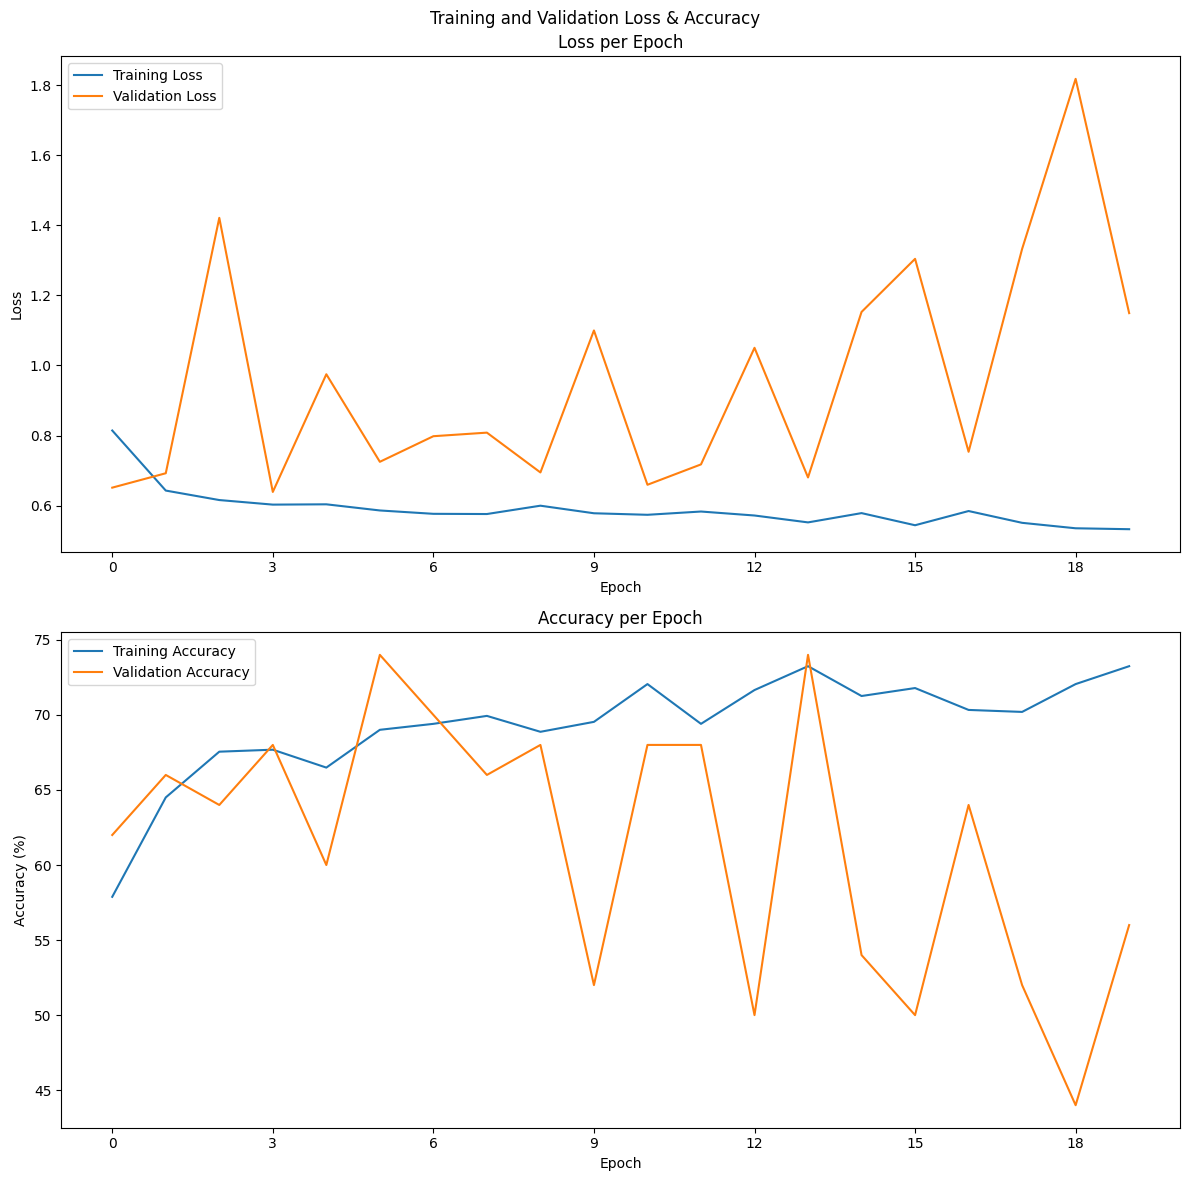

Best Model was at epoch 4 with Validation Loss: 0.6391


In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Training and Validation Loss & Accuracy')

# Plot for loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss per Epoch')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plot for accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.set_title('Accuracy per Epoch')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

print(f"Best Model was at epoch {best_epoch+1} with Validation Loss: {best_val_loss:.4f}")

Simple_RMSprop_bn_train_losses = train_losses
Simple_RMSprop_bn_train_acc = train_accuracies
Simple_RMSprop_bn_val_losses = val_losses
Simple_RMSprop_bn_val_acc = val_accuracies

In [44]:
# Evaluating the model

# Load the best model
best_model_path = '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_Simple_RMSprop_bn.pth'
model_bn.load_state_dict(torch.load(best_model_path, map_location=device))

model_bn.eval()

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_bn(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.4672, Test Accuracy: 76.92%


### Adam

In [45]:
# Instantiate the model
model_bn = SimpleCNN_bn()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bn.parameters(), lr=0.00001, weight_decay = 0.00001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bn.to(device)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
best_epoch = 0

for epoch in range(num_epochs):
    model_bn.train()  # Set the model to training mode
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass
        outputs = model_bn(images)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model_bn.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model_bn(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        # Save the model state
        torch.save(model_bn.state_dict(), '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_Simple_Adam_bn.pth')
        print(f"Best model saved at epoch {epoch+1} with Validation Loss: {avg_val_loss:.4f}")

    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


Best model saved at epoch 1 with Validation Loss: 0.5942
Epoch [1/20], Train Loss: 0.6732, Train Acc: 59.74%, Val Loss: 0.5942, Val Acc: 70.00%
Epoch [2/20], Train Loss: 0.6298, Train Acc: 64.77%, Val Loss: 0.7327, Val Acc: 70.00%
Epoch [3/20], Train Loss: 0.6114, Train Acc: 66.23%, Val Loss: 0.8918, Val Acc: 70.00%
Epoch [4/20], Train Loss: 0.6235, Train Acc: 66.62%, Val Loss: 0.7622, Val Acc: 66.00%
Epoch [5/20], Train Loss: 0.6226, Train Acc: 65.03%, Val Loss: 0.7997, Val Acc: 74.00%
Epoch [6/20], Train Loss: 0.6032, Train Acc: 67.02%, Val Loss: 0.9659, Val Acc: 72.00%
Epoch [7/20], Train Loss: 0.5535, Train Acc: 71.92%, Val Loss: 0.9835, Val Acc: 72.00%
Epoch [8/20], Train Loss: 0.5766, Train Acc: 70.20%, Val Loss: 1.3865, Val Acc: 58.00%
Epoch [9/20], Train Loss: 0.5905, Train Acc: 68.48%, Val Loss: 0.9430, Val Acc: 70.00%
Epoch [10/20], Train Loss: 0.5612, Train Acc: 72.58%, Val Loss: 0.8400, Val Acc: 70.00%
Epoch [11/20], Train Loss: 0.5722, Train Acc: 70.73%, Val Loss: 1.7123, 

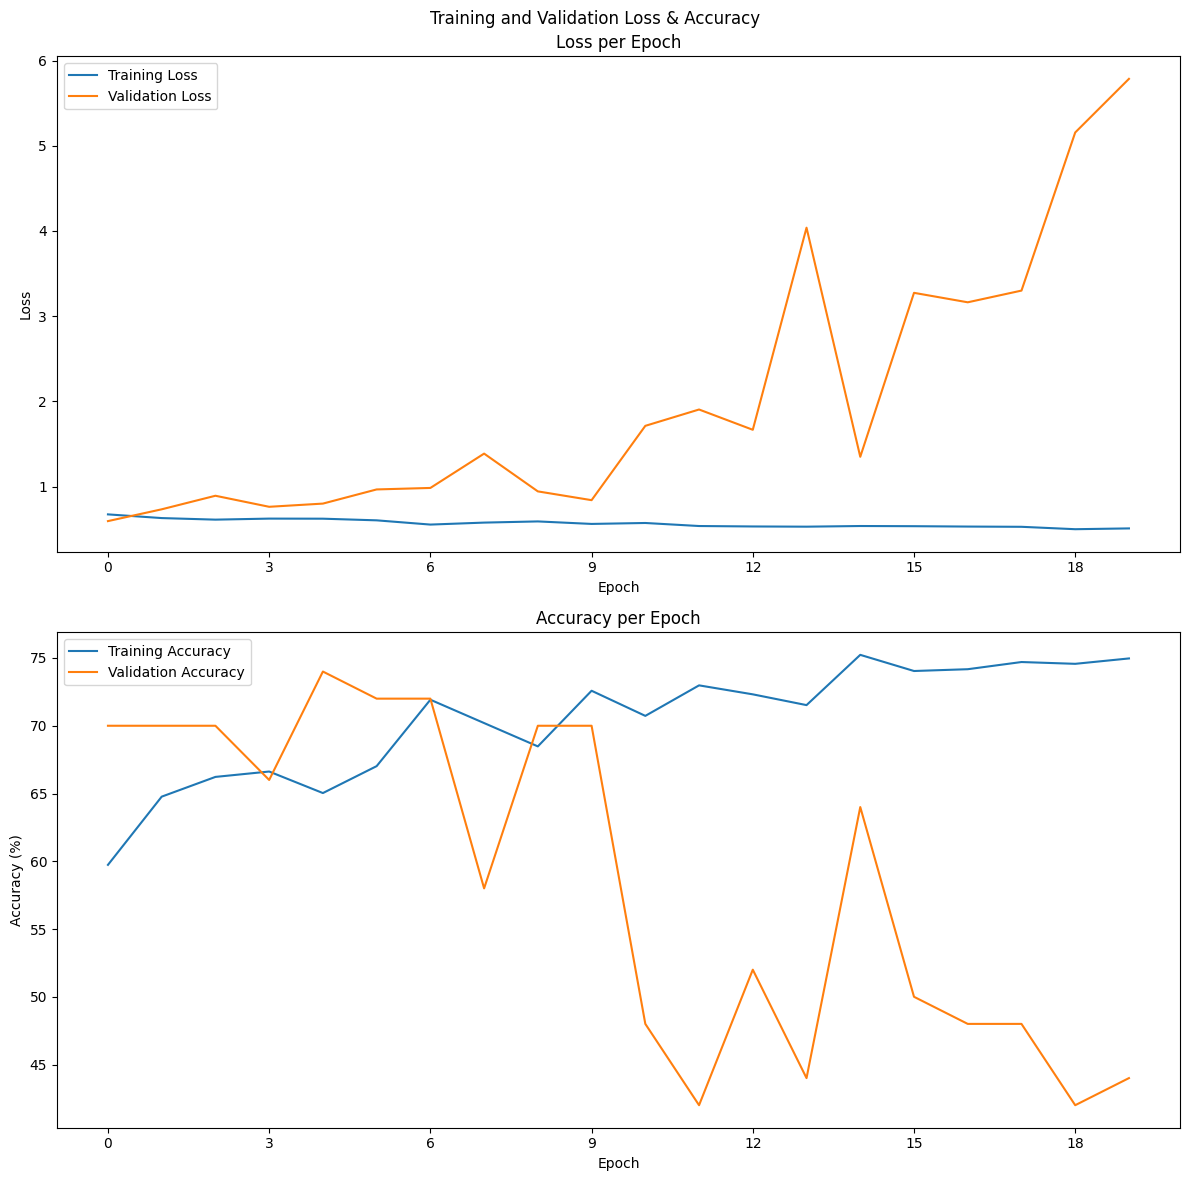

Best Model was at epoch 1 with Validation Loss: 0.5942


In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Training and Validation Loss & Accuracy')

# Plot for loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss per Epoch')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plot for accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.set_title('Accuracy per Epoch')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

print(f"Best Model was at epoch {best_epoch+1} with Validation Loss: {best_val_loss:.4f}")

Simple_Adam_bn_train_losses = train_losses
Simple_Adam_bn_train_acc = train_accuracies
Simple_Adam_bn_val_losses = val_losses
Simple_Adam_bn_val_acc = val_accuracies

In [47]:
# Evaluating the model

# Load the best model
best_model_path = '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_Simple_Adam_bn.pth'
model_bn.load_state_dict(torch.load(best_model_path, map_location=device))

model_bn.eval()

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_bn(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.5463, Test Accuracy: 78.85%


## Pre-trained Models

### VGG

In [ ]:
# Load pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze the layers of VGG16
for param in vgg16.parameters():
    param.requires_grad = False

# Unfreeze the top convolutional layers of VGG16
num_conv_to_unfreeze = 10
conv_count = 0
for layer in reversed(vgg16.features):
    if isinstance(layer, nn.Conv2d):
        layer.requires_grad = True
        conv_count += 1
        if conv_count >= num_conv_to_unfreeze:
            break

# Replace the classifier part of VGG16
num_features = vgg16.classifier[0].in_features
vgg16.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)

# Move model to the right device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Gradient Descent

In [ ]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD([
    {'params': vgg16.features.parameters(), 'lr': 1e-5},
    {'params': vgg16.classifier.parameters(), 'lr': 1e-4}
], momentum = 0)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
best_epoch = 0

for epoch in range(num_epochs):
    vgg16.train()  # Set the model to training mode
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
        labels = labels.float()

        # Forward pass
        outputs = vgg16(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        # Calculate training accuracy
        predicted = (outputs > 0.5).float()  # Convert probabilities to 0 or 1 based on a threshold of 0.5
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    vgg16.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
            labels = labels.float()
            outputs = vgg16(images)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Calculate validation accuracy
            predicted = (outputs > 0.5).float()  # Convert probabilities to 0 or 1 based on a threshold of 0.5
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        # Save the model state
        torch.save(vgg16.state_dict(), '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_vgg_GD.pth')
        print(f"Best model saved at epoch {epoch+1} with Validation Loss: {avg_val_loss:.4f}")

    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


Best model saved at epoch 1 with Validation Loss: 0.7094
Epoch [1/20], Train Loss: 0.6523, Train Acc: 42.65%, Val Loss: 0.7094, Val Acc: 46.00%
Epoch [2/20], Train Loss: 0.6493, Train Acc: 43.71%, Val Loss: 0.7097, Val Acc: 48.00%
Epoch [3/20], Train Loss: 0.6504, Train Acc: 45.83%, Val Loss: 0.7101, Val Acc: 48.00%
Epoch [4/20], Train Loss: 0.6515, Train Acc: 47.02%, Val Loss: 0.7103, Val Acc: 46.00%
Epoch [5/20], Train Loss: 0.6500, Train Acc: 46.75%, Val Loss: 0.7106, Val Acc: 48.00%
Epoch [6/20], Train Loss: 0.6485, Train Acc: 51.39%, Val Loss: 0.7109, Val Acc: 48.00%
Epoch [7/20], Train Loss: 0.6447, Train Acc: 56.03%, Val Loss: 0.7113, Val Acc: 48.00%
Epoch [8/20], Train Loss: 0.6458, Train Acc: 53.91%, Val Loss: 0.7117, Val Acc: 50.00%
Epoch [9/20], Train Loss: 0.6459, Train Acc: 54.83%, Val Loss: 0.7119, Val Acc: 52.00%
Epoch [10/20], Train Loss: 0.6456, Train Acc: 55.50%, Val Loss: 0.7123, Val Acc: 54.00%
Epoch [11/20], Train Loss: 0.6454, Train Acc: 56.42%, Val Loss: 0.7124, 

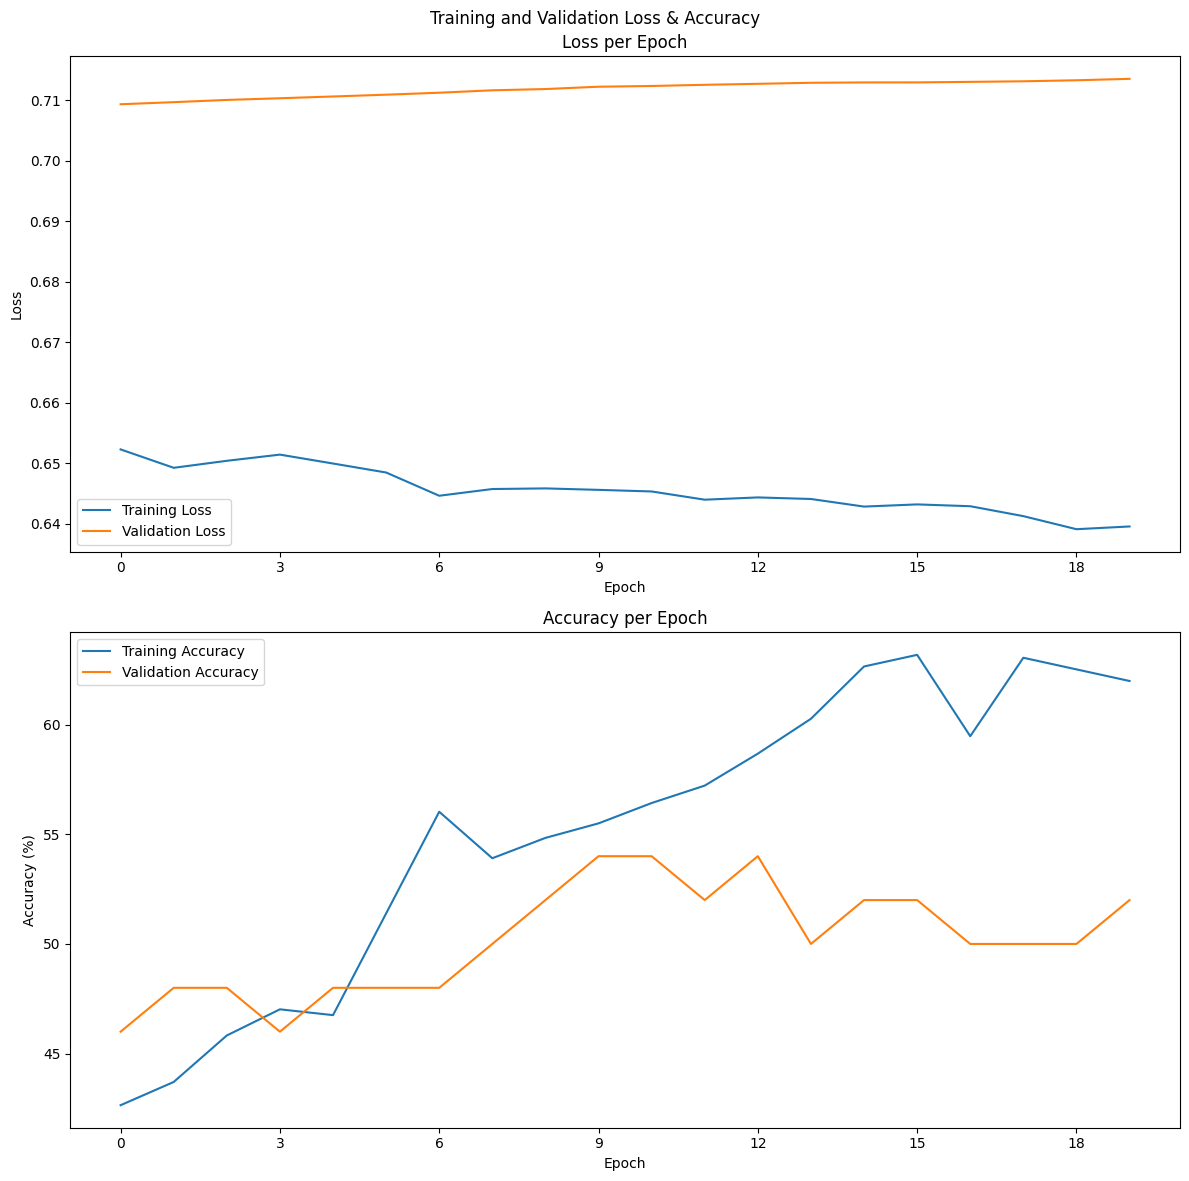

Best Model was at epoch 1 with Validation Loss: 0.7094


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Training and Validation Loss & Accuracy')

# Plot for loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss per Epoch')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plot for accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.set_title('Accuracy per Epoch')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

print(f"Best Model was at epoch {best_epoch+1} with Validation Loss: {best_val_loss:.4f}")

VGG_GD_train_losses = train_losses
VGG_GD_train_acc = train_accuracies
VGG_GD_val_losses = val_losses
VGG_GD_val_acc = val_accuracies

In [ ]:
# Evaluating the model

# Load the best model
best_model_path = '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_vgg_GD.pth'
vgg16.load_state_dict(torch.load(best_model_path, map_location=device))

vgg16.eval()

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float()
        outputs = vgg16(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.6834, Test Accuracy: 40.38%


#### Stocastic Gradient Descent

In [ ]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD([
    {'params': vgg16.features.parameters(), 'lr': 1e-5},  # Lower learning rate for the newly unfrozen layers
    {'params': vgg16.classifier.parameters(), 'lr': 1e-4}
], weight_decay=1e-4)  # Add weight decay for regularization

# Training loop
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
best_epoch = 0

for epoch in range(num_epochs):
    vgg16.train()  # Set the model to training mode
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
        labels = labels.float()

        # Forward pass
        outputs = vgg16(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        # Calculate training accuracy
        predicted = (outputs > 0.5).float()  # Convert probabilities to 0 or 1 based on a threshold of 0.5
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    vgg16.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
            labels = labels.float()
            outputs = vgg16(images)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Calculate validation accuracy
            predicted = (outputs > 0.5).float()  # Convert probabilities to 0 or 1 based on a threshold of 0.5
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        # Save the model state
        torch.save(vgg16.state_dict(), '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_vgg_SGD.pth')
        print(f"Best model saved at epoch {epoch+1} with Validation Loss: {avg_val_loss:.4f}")

    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


Best model saved at epoch 1 with Validation Loss: 0.7096
Epoch [1/20], Train Loss: 0.6520, Train Acc: 43.05%, Val Loss: 0.7096, Val Acc: 48.00%
Epoch [2/20], Train Loss: 0.6503, Train Acc: 43.58%, Val Loss: 0.7099, Val Acc: 48.00%
Epoch [3/20], Train Loss: 0.6483, Train Acc: 48.08%, Val Loss: 0.7101, Val Acc: 44.00%
Epoch [4/20], Train Loss: 0.6487, Train Acc: 47.68%, Val Loss: 0.7102, Val Acc: 46.00%
Epoch [5/20], Train Loss: 0.6501, Train Acc: 49.27%, Val Loss: 0.7105, Val Acc: 48.00%
Epoch [6/20], Train Loss: 0.6494, Train Acc: 50.99%, Val Loss: 0.7108, Val Acc: 48.00%
Epoch [7/20], Train Loss: 0.6467, Train Acc: 53.64%, Val Loss: 0.7111, Val Acc: 48.00%
Epoch [8/20], Train Loss: 0.6450, Train Acc: 55.76%, Val Loss: 0.7112, Val Acc: 50.00%
Epoch [9/20], Train Loss: 0.6457, Train Acc: 56.95%, Val Loss: 0.7112, Val Acc: 52.00%
Epoch [10/20], Train Loss: 0.6430, Train Acc: 57.48%, Val Loss: 0.7114, Val Acc: 52.00%
Epoch [11/20], Train Loss: 0.6447, Train Acc: 55.10%, Val Loss: 0.7117, 

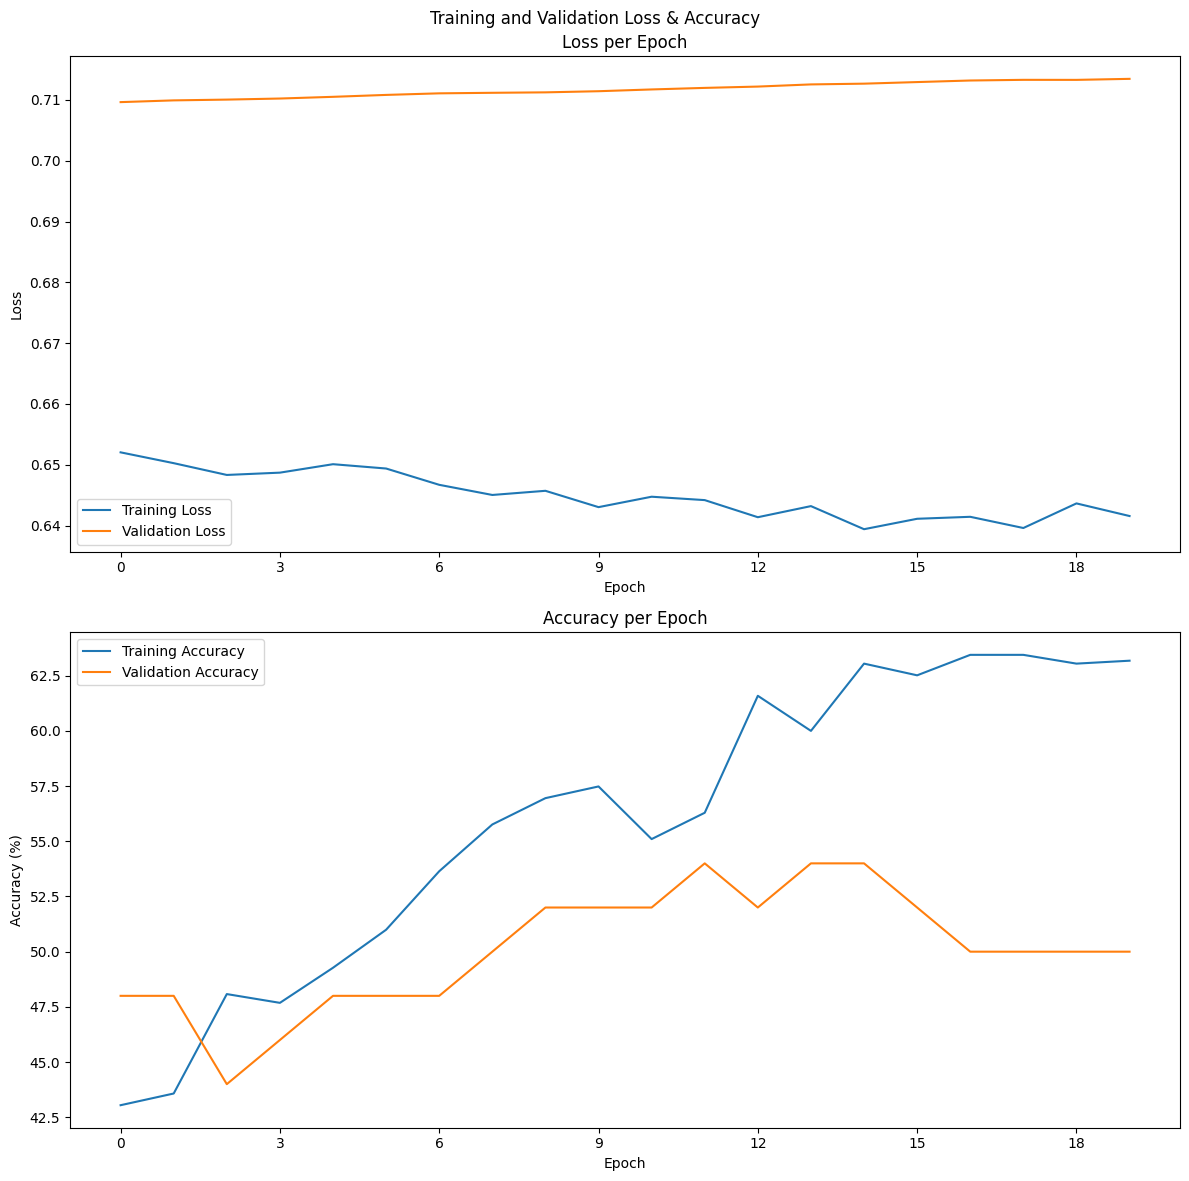

Best Model was at epoch 1 with Validation Loss: 0.7096


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Training and Validation Loss & Accuracy')

# Plot for loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss per Epoch')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plot for accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.set_title('Accuracy per Epoch')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

print(f"Best Model was at epoch {best_epoch+1} with Validation Loss: {best_val_loss:.4f}")

VGG_SGD_train_losses = train_losses
VGG_SGD_train_acc = train_accuracies
VGG_SGD_val_losses = val_losses
VGG_SGD_val_acc = val_accuracies

In [ ]:
# Evaluating the model

# Load the best model
best_model_path = '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_vgg_SGD.pth'
vgg16.load_state_dict(torch.load(best_model_path, map_location=device))

vgg16.eval()

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float()
        outputs = vgg16(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.6835, Test Accuracy: 40.38%


#### RMSprop

In [ ]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop([
    {'params': vgg16.features.parameters(), 'lr': 1e-5},  # Lower learning rate for the newly unfrozen layers
    {'params': vgg16.classifier.parameters(), 'lr': 1e-4}
], weight_decay=1e-4)  # Add weight decay for regularization

# Training loop
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
best_epoch = 0

for epoch in range(num_epochs):
    vgg16.train()  # Set the model to training mode
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
        labels = labels.float()

        # Forward pass
        outputs = vgg16(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        # Calculate training accuracy
        predicted = (outputs > 0.5).float()  # Convert probabilities to 0 or 1 based on a threshold of 0.5
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    vgg16.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
            labels = labels.float()
            outputs = vgg16(images)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Calculate validation accuracy
            predicted = (outputs > 0.5).float()  # Convert probabilities to 0 or 1 based on a threshold of 0.5
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        # Save the model state
        torch.save(vgg16.state_dict(), '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_vgg_RMSprop.pth')
        print(f"Best model saved at epoch {epoch+1} with Validation Loss: {avg_val_loss:.4f}")

    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


Best model saved at epoch 1 with Validation Loss: 0.7214
Epoch [1/20], Train Loss: 0.6064, Train Acc: 70.60%, Val Loss: 0.7214, Val Acc: 56.00%
Best model saved at epoch 2 with Validation Loss: 0.7170
Epoch [2/20], Train Loss: 0.5903, Train Acc: 75.76%, Val Loss: 0.7170, Val Acc: 58.00%
Epoch [3/20], Train Loss: 0.5846, Train Acc: 74.70%, Val Loss: 0.7556, Val Acc: 52.00%
Epoch [4/20], Train Loss: 0.5790, Train Acc: 77.48%, Val Loss: 0.7437, Val Acc: 54.00%
Epoch [5/20], Train Loss: 0.5746, Train Acc: 77.75%, Val Loss: 0.7531, Val Acc: 54.00%
Epoch [6/20], Train Loss: 0.5738, Train Acc: 77.22%, Val Loss: 0.7656, Val Acc: 52.00%
Epoch [7/20], Train Loss: 0.5708, Train Acc: 79.34%, Val Loss: 0.7502, Val Acc: 54.00%
Epoch [8/20], Train Loss: 0.5729, Train Acc: 77.75%, Val Loss: 0.7548, Val Acc: 54.00%
Epoch [9/20], Train Loss: 0.5662, Train Acc: 79.21%, Val Loss: 0.7557, Val Acc: 54.00%
Epoch [10/20], Train Loss: 0.5628, Train Acc: 80.00%, Val Loss: 0.7585, Val Acc: 54.00%
Epoch [11/20], 

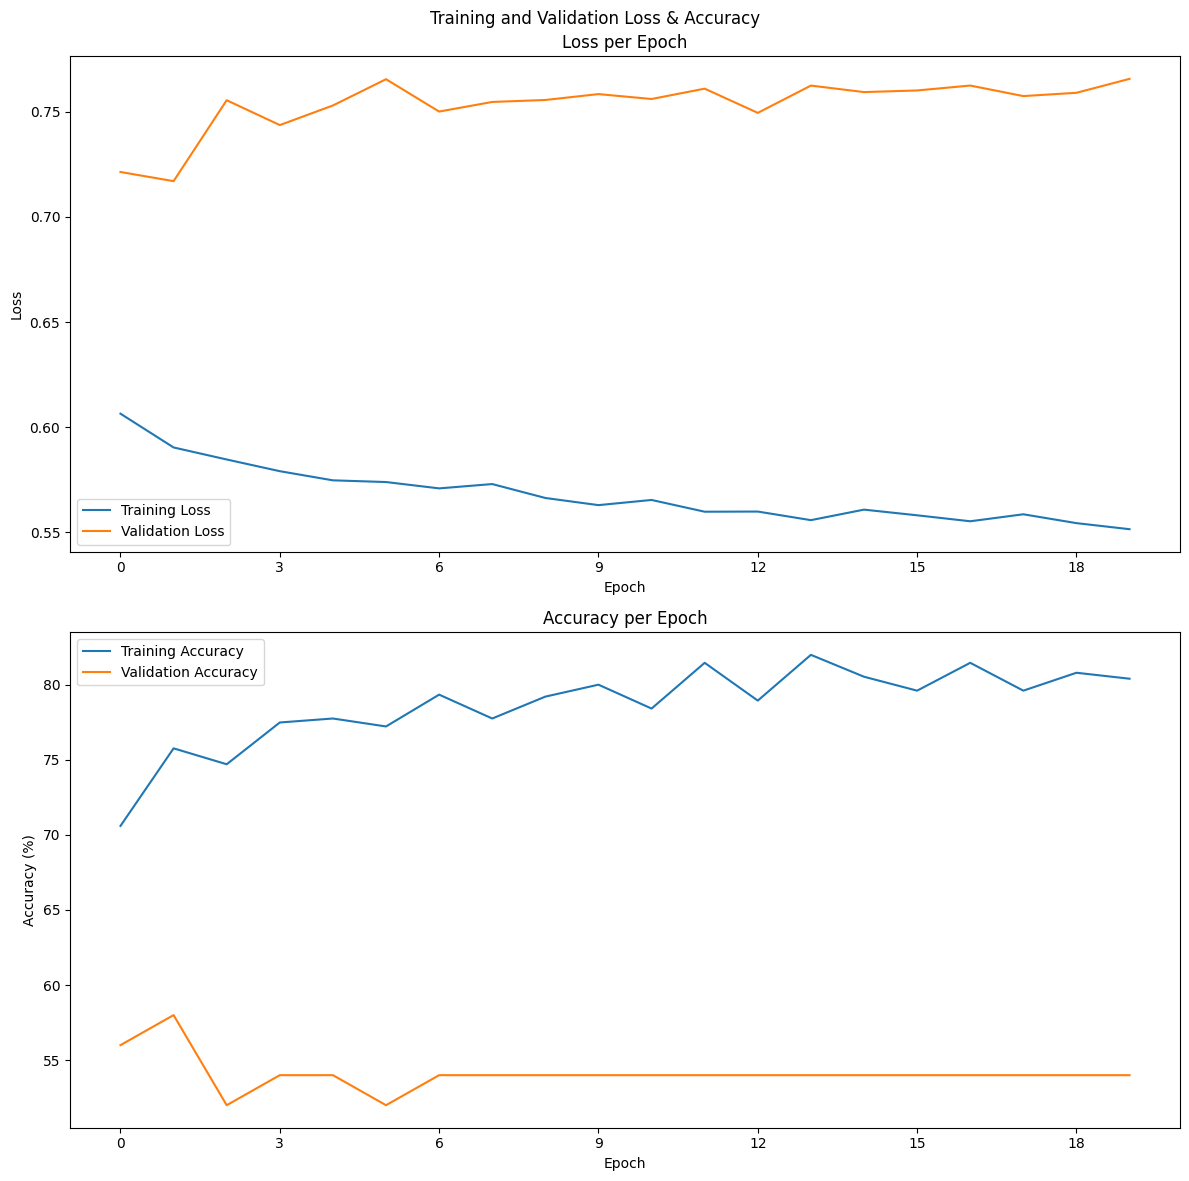

Best Model was at epoch 2 with Validation Loss: 0.7170


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Training and Validation Loss & Accuracy')

# Plot for loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss per Epoch')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plot for accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.set_title('Accuracy per Epoch')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

print(f"Best Model was at epoch {best_epoch+1} with Validation Loss: {best_val_loss:.4f}")

VGG_RMSprop_train_losses = train_losses
VGG_RMSprop_train_acc = train_accuracies
VGG_RMSprop_val_losses = val_losses
VGG_RMSprop_val_acc = val_accuracies

In [ ]:
# Evaluating the model

# Load the best model
best_model_path = '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_vgg_RMSprop.pth'
vgg16.load_state_dict(torch.load(best_model_path, map_location=device))

vgg16.eval()

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float()
        outputs = vgg16(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.6867, Test Accuracy: 61.54%


#### Adam

In [ ]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam([
    {'params': vgg16.features.parameters(), 'lr': 1e-5},  # Lower learning rate for the newly unfrozen layers
    {'params': vgg16.classifier.parameters(), 'lr': 1e-4}
], weight_decay=1e-4)  # Add weight decay for regularization

# Training loop
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
best_epoch = 0

for epoch in range(num_epochs):
    vgg16.train()  # Set the model to training mode
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
        labels = labels.float()

        # Forward pass
        outputs = vgg16(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        # Calculate training accuracy
        predicted = (outputs > 0.5).float()  # Convert probabilities to 0 or 1 based on a threshold of 0.5
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    vgg16.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
            labels = labels.float()
            outputs = vgg16(images)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Calculate validation accuracy
            predicted = (outputs > 0.5).float()  # Convert probabilities to 0 or 1 based on a threshold of 0.5
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        # Save the model state
        torch.save(vgg16.state_dict(), '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_vgg_Adam.pth')
        print(f"Best model saved at epoch {epoch+1} with Validation Loss: {avg_val_loss:.4f}")

    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


Best model saved at epoch 1 with Validation Loss: 0.7571
Epoch [1/20], Train Loss: 0.5858, Train Acc: 76.56%, Val Loss: 0.7571, Val Acc: 52.00%
Best model saved at epoch 2 with Validation Loss: 0.7557
Epoch [2/20], Train Loss: 0.5796, Train Acc: 75.23%, Val Loss: 0.7557, Val Acc: 52.00%
Epoch [3/20], Train Loss: 0.5805, Train Acc: 76.03%, Val Loss: 0.7610, Val Acc: 52.00%
Best model saved at epoch 4 with Validation Loss: 0.7509
Epoch [4/20], Train Loss: 0.5760, Train Acc: 75.23%, Val Loss: 0.7509, Val Acc: 54.00%
Epoch [5/20], Train Loss: 0.5732, Train Acc: 78.28%, Val Loss: 0.7629, Val Acc: 54.00%
Epoch [6/20], Train Loss: 0.5700, Train Acc: 76.42%, Val Loss: 0.7530, Val Acc: 54.00%
Epoch [7/20], Train Loss: 0.5611, Train Acc: 80.79%, Val Loss: 0.7642, Val Acc: 54.00%
Epoch [8/20], Train Loss: 0.5636, Train Acc: 79.21%, Val Loss: 0.7611, Val Acc: 54.00%
Epoch [9/20], Train Loss: 0.5675, Train Acc: 78.15%, Val Loss: 0.7579, Val Acc: 54.00%
Epoch [10/20], Train Loss: 0.5626, Train Acc: 

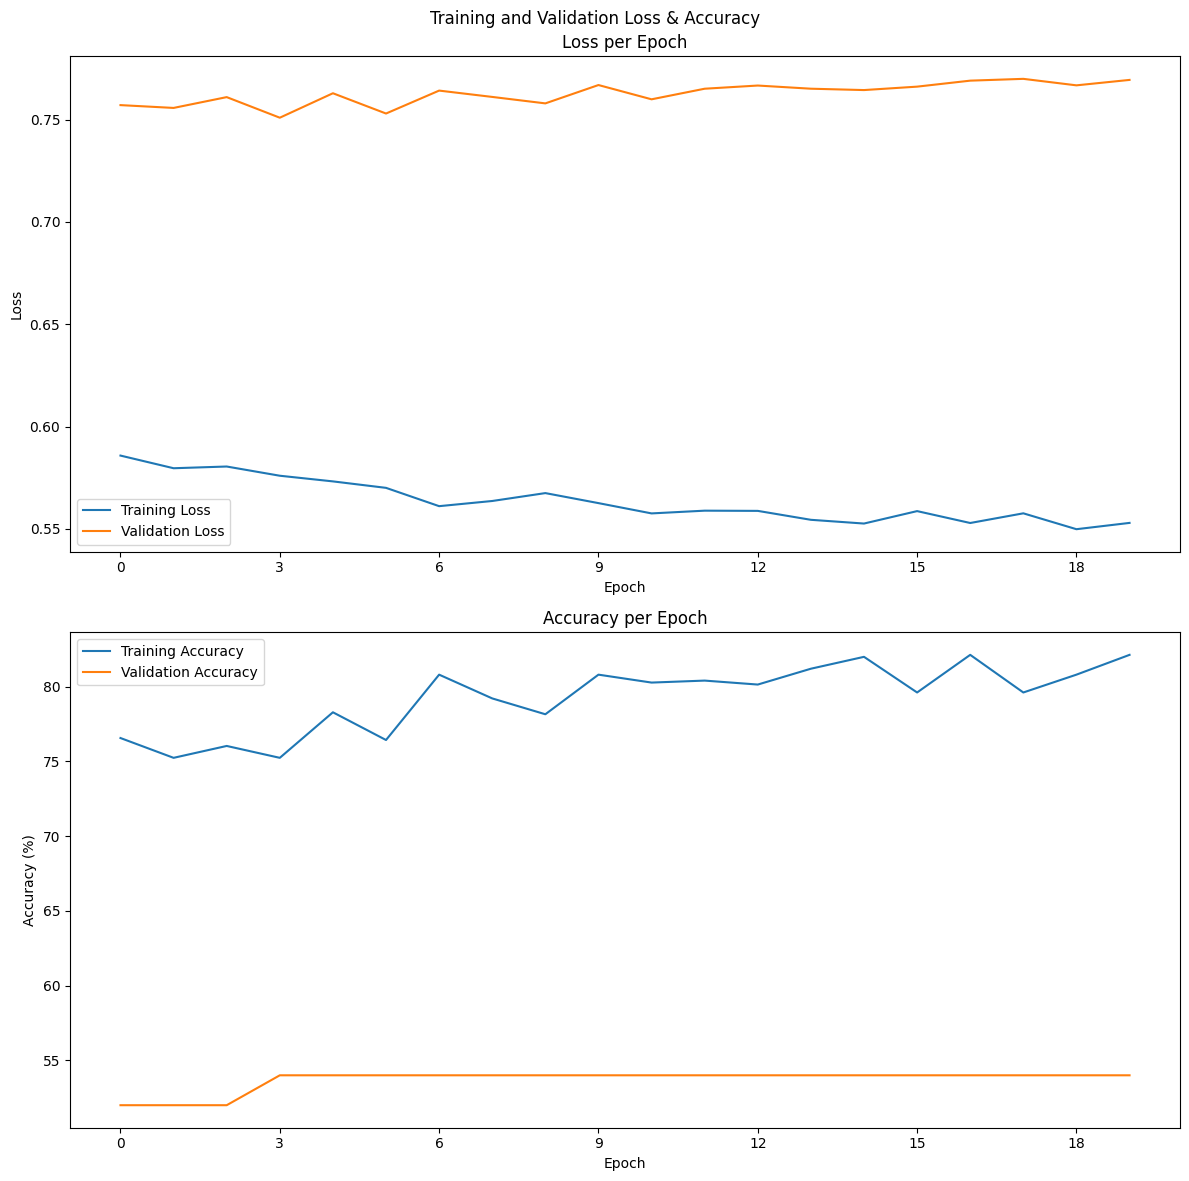

Best Model was at epoch 4 with Validation Loss: 0.7509


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Training and Validation Loss & Accuracy')

# Plot for loss
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss per Epoch')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plot for accuracy
ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.set_title('Accuracy per Epoch')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

print(f"Best Model was at epoch {best_epoch+1} with Validation Loss: {best_val_loss:.4f}")

VGG_Adam_train_losses = train_losses
VGG_Adam_train_acc = train_accuracies
VGG_Adam_val_losses = val_losses
VGG_Adam_val_acc = val_accuracies

In [ ]:
# Evaluating the model

# Load the best model
best_model_path = '/content/drive/MyDrive/Adelaide/Trimester 5/DLF/Assignment/A2/best_model_state_vgg_Adam.pth'
vgg16.load_state_dict(torch.load(best_model_path, map_location=device))

vgg16.eval()

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float()
        outputs = vgg16(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.7124, Test Accuracy: 57.69%


# Results

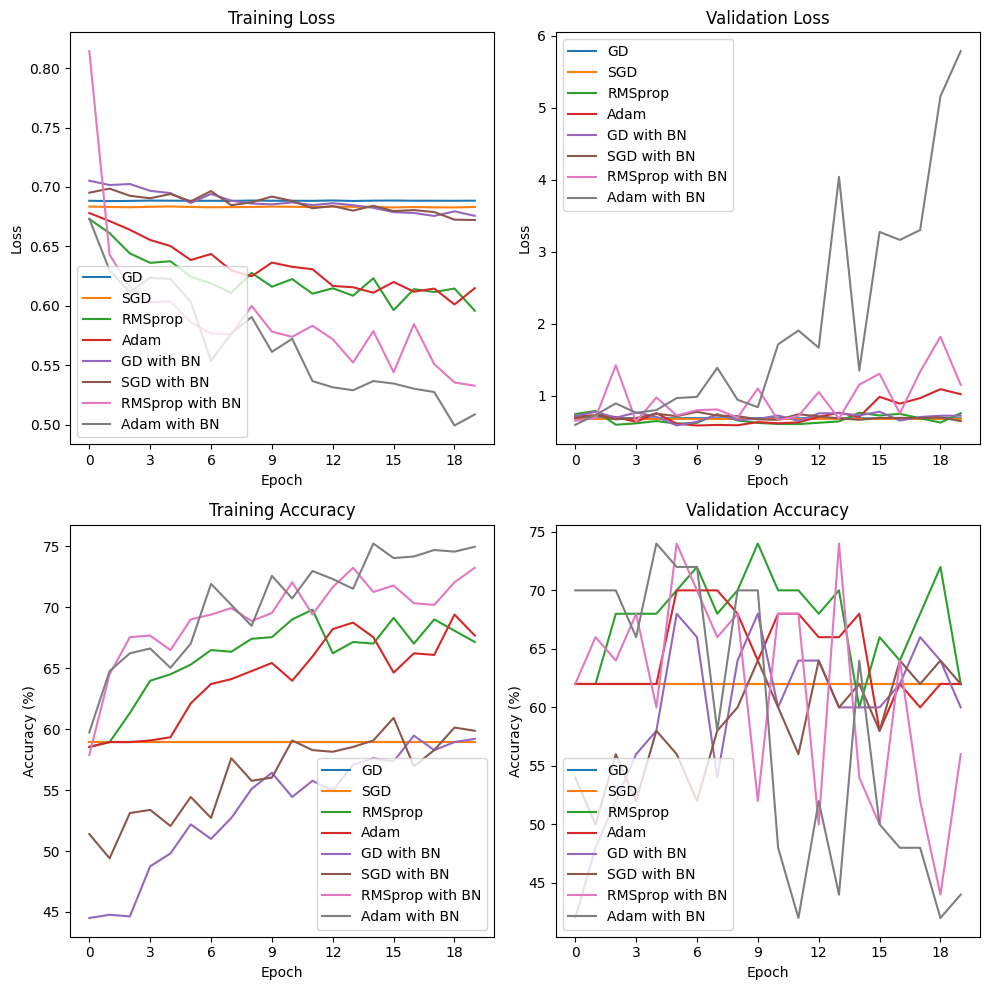

In [52]:
# Base model

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(Simple_GD_train_losses, label='GD')
axs[0, 0].plot(Simple_SGD_train_losses, label='SGD')
axs[0, 0].plot(Simple_RMSprop_train_losses, label='RMSprop')
axs[0, 0].plot(Simple_Adam_train_losses, label='Adam')
axs[0, 0].plot(Simple_GD_bn_train_losses, label='GD with BN')
axs[0, 0].plot(Simple_SGD_bn_train_losses, label='SGD with BN')
axs[0, 0].plot(Simple_RMSprop_bn_train_losses, label='RMSprop with BN')
axs[0, 0].plot(Simple_Adam_bn_train_losses, label='Adam with BN')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].set_title('Training Loss')
axs[0, 0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[0, 1].plot(Simple_GD_val_losses, label='GD')
axs[0, 1].plot(Simple_SGD_val_losses, label='SGD')
axs[0, 1].plot(Simple_RMSprop_val_losses, label='RMSprop')
axs[0, 1].plot(Simple_Adam_val_losses, label='Adam')
axs[0, 1].plot(Simple_GD_bn_val_losses, label='GD with BN')
axs[0, 1].plot(Simple_SGD_bn_val_losses, label='SGD with BN')
axs[0, 1].plot(Simple_RMSprop_bn_val_losses, label='RMSprop with BN')
axs[0, 1].plot(Simple_Adam_bn_val_losses, label='Adam with BN')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].set_title('Validation Loss')
axs[0, 1].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1, 0].plot(Simple_GD_train_acc, label='GD')
axs[1, 0].plot(Simple_SGD_train_acc, label='SGD')
axs[1, 0].plot(Simple_RMSprop_train_acc, label='RMSprop')
axs[1, 0].plot(Simple_Adam_train_acc, label='Adam')
axs[1, 0].plot(Simple_GD_bn_train_acc, label='GD with BN')
axs[1, 0].plot(Simple_SGD_bn_train_acc, label='SGD with BN')
axs[1, 0].plot(Simple_RMSprop_bn_train_acc, label='RMSprop with BN')
axs[1, 0].plot(Simple_Adam_bn_train_acc, label='Adam with BN')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy (%)')
axs[1, 0].legend()
axs[1, 0].set_title('Training Accuracy')
axs[1, 0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1, 1].plot(Simple_GD_val_acc, label='GD')
axs[1, 1].plot(Simple_SGD_val_acc, label='SGD')
axs[1, 1].plot(Simple_RMSprop_val_acc, label='RMSprop')
axs[1, 1].plot(Simple_Adam_val_acc, label='Adam')
axs[1, 1].plot(Simple_GD_bn_val_acc, label='GD with BN')
axs[1, 1].plot(Simple_SGD_bn_val_acc, label='SGD with BN')
axs[1, 1].plot(Simple_RMSprop_bn_val_acc, label='RMSprop with BN')
axs[1, 1].plot(Simple_Adam_bn_val_acc, label='Adam with BN')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy (%)')
axs[1, 1].legend()
axs[1, 1].set_title('Validation Accuracy')
axs[1, 1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()